# Text Classification: Word Embeddings + Convolution

In this notebook, I demonstrate how to create and train a deep neural network that uses **word embeddings** and a **Convolution** layer to
extract both hard and soft skills from job post descriptions.

## Table of contents

1. [Environment](#Environment)
   1. [Imports and Datasets](#Imports-and-Datasets)
   2. [Under-sampling](#Under-sampling)
   3. [Dataset Preparation](#Dataset-Preparation)
   4. [Text Encoder](#Text-Encoder)
2. [Model and Training](#Model-and-Training)
   1. [Configuration](#Configuration)
   2. [Callbacks](#Callbacks)
   3. [Training](#Training)
3. [Results and Visualizations](#Results-and-Visualizations)
   1. [Noun Chunk Extraction](#Noun-Chunk-Extraction)
   2. [Predictions](#Predictions)
   3. [Embedding Vectors](#Embedding-Vectors)
   4. [Wordcloud Visualizations](#Wordcloud-Visualizations)

## Environment

### Imports and Datasets

In [1]:
import sys
sys.path.append("..")
sys.path.append("../modeling/")

In [2]:
import io
import random
import numpy as np
from numpy.linalg import norm
import pandas as pd                # Data processing

# Visualization imports
import matplotlib.pyplot as plt    # Data visualization purposes
import seaborn as sns              # Statistical data visualization
sns.set_theme()                    # Seaborn will handle plotting theme
%matplotlib inline
from wordcloud import WordCloud    # Wordcloud visualizations

# Scikit-learn imports
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

# Tensorflow imports
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization, Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras import Sequential

# Database imports
from modeling.database import MongoDB

# NLP imports
import spacy

Let's load the complete dataset as well as the training dataset. This set is contained within the `noun_chunks_classified.csv` file which contains<br>
noun phrases classified by "*not_skill*", "*hard_skill*", or "*soft_skill*".

In [3]:
db = MongoDB()
complete_df = pd.DataFrame(list(db.get_all_documents()))

In [4]:
df = pd.read_csv('noun_chunks_classified.csv')
df['type'].value_counts()

not_skill     3406
hard_skill     524
soft_skill      70
Name: type, dtype: int64

### Under-sampling

Like in a previous notebook, we are going to perform undersampling to balance the class distribution of the dataset by reducing the size of the majority class.<br>
This is done to prevent the model from being biased towards the majority class and to improve its performance on the minority class.

In [5]:
df_skills     = df[df['type'] != "not_skill"]
df_not_skills = df[df['type'] == "not_skill"].sample(n=700)
df = pd.concat([df_skills, df_not_skills], ignore_index=True)

### Dataset Preparation

In [6]:
test_ratio = 0.3

# Extract features and prediction vectors
X = df['chunks']
y = df['type'].map({'not_skill':0, 'hard_skill':1, 'soft_skill':2})

# Split into train, test and validation sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size = test_ratio, random_state = 0)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size = 0.5, random_state = 0)

In [7]:
print('Shape of train set:\t', X_train.shape)
print('Shape of validation set:\t', X_val.shape)
print('Shape of test set:\t', X_test.shape)
print('Maximum phrase length:\t', X.str.split().str.len().max())

Shape of train set:	 (905,)
Shape of validation set:	 (194,)
Shape of test set:	 (195,)
Maximum phrase length:	 18


In [8]:
BUFFER_SIZE = 1024
BATCH_SIZE = 64

# Prepare the training dataset
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

# Prepare the validation dataset
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_ds = val_ds.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

# Prepare the testing dataset
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_ds = test_ds.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

As per tensorflow tutorial: https://www.tensorflow.org/text/guide/word_embeddings#configure_the_dataset_for_performance

`.cache()`: Keeps data in memory after it's loaded off disk. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache, which is more efficient to read than many small files.

`.prefetch()`: Overlaps data preprocessing and model execution while training.

`tf.data.AUTOTUNE`: Automatically tunes the prefetch buffer size based on available system memory and other factors.

In [9]:
print('Label\t', 'Noun Chunks')
for example, label in train_ds.take(1):
    for i in range(3):
        print(label.numpy()[i], "\t", example.numpy()[i])

Label	 Noun Chunks
0 	 b'data model'
0 	 b'prototype code'
1 	 b'Greek and English additional languages'


### Text Encoder

In [10]:
# Custom standardization function to strip remove uneccessary text and symbols.
def custom_standardization(input_data):
    input_df = tf.strings.lower(input_data)
    input_df = tf.strings.regex_replace(input_df, '(e.g.?)|(i.e.?).', '')
    input_df = tf.strings.regex_replace(input_df, '[^\u0020-\u007E]', ' ')
    input_df = tf.strings.regex_replace(input_df, '\b[\w\.-]+@[\w\.-]+\.\w{2,6}\b', '')
    input_df = tf.strings.regex_replace(input_df, '(https?:\/\/)?([\da-z\.-]+)\.([a-z\.]{2,6})([\/\w \.-]*)', '')
    input_df = tf.strings.regex_replace(input_df, '\B#([a-z0-9]{1,})', ' ')
    input_df = tf.strings.regex_replace(input_df, '[^\w\s+#]', ' ')
    
    return tf.strings.regex_replace(input_df, '(\s{2,})|(\n+)', ' ')

In [11]:
# Vocabulary size and number of words in a sequence.
vocab_size = 2500
sequence_length = 18

# Use the text vectorization layer to normalize, split, and map strings to integers.
# Note that the layer uses the custom standardization defined above.
# Set maximum_sequence length as all samples are not of the same length.
vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length)

vectorize_layer.adapt(X_train)

In [12]:
vocabulary = vectorize_layer.get_vocabulary()
print('Vocabulary size: {}'.format(len(vocabulary)))

num = random.randint(1, len(vocabulary))
print(f"Word with number {num} represents -->", vocabulary[num])

Vocabulary size: 1140
Word with number 378 represents --> bsc


In [13]:
encoded_example = vectorize_layer(example)[:3].numpy()
print('Noun Chunk:\t', example[0].numpy())
print('Encoded:\t', encoded_example[0])

Noun Chunk:	 b'data model'
Encoded:	 [  2 106   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]


## Model and Training

In this notebook I will use `word embeddings` are a way of representing words as dense vectors of real numbers. They are used in natural language processing
(NLP) to encode words in a way that allows them to be used as input to machine learning models. The main advantage of word embeddings is that they allow us
to use an efficient, dense representation in which similar words have a similar encoding. This makes it possible to use machine learning algorithms to analyze
text data and perform tasks such as sentiment analysis, text classification, and machine translation.

In text classification models, `Conv1D` is used to recognize topics and relationships between words. It is a feature transformation that groups a set of sequential
data into a convoluted, compressed data. In general, Conv1D takes care of neighboring words by using a filter length that implies a context window of words.

### Configuration

I will now create my deep learning model using TensorFlow's Keras API. I define a neural network model that takes a string as input and outputs a <br>
probability distribution over three classes. In more detail:

1. `embedding_dim`: Sets the dimensionality of the word embeddings that will be learned by the model to 16.
2. `tf.keras.Input()`: This line defines an input layer that takes a string as input.
3. `vectorize_layer`: Defines a layer that converts the input string into a sequence of integers.
4. `Embedding()`: Defines an embedding layer that maps each integer in the input sequence to a dense vector of dimensionality `embedding_dim`.
5. `Conv1D()`: Defines a 1D convolution layer with 64 filters and a kernel size of 5.
6. `GlobalAveragePooling1D()`: Applies global average pooling to the output of the embedding layer.
7. `Dense(16, activation='relu')`: Adds a fully connected layer with 16 units and ReLU activation.
8. `Dense(3, activation='softmax')`: Adds a fully connected layer with 3 units and softmax activation, which outputs a probability distribution over three classes.

In [14]:
embedding_dim = 64

model = tf.keras.Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    vectorize_layer,
    Embedding(vocab_size, embedding_dim, name="embedding"),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    GlobalAveragePooling1D(),
    Dense(16, activation='relu'),
    Dense(3, activation='softmax')
])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 18)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 18, 64)            160000    
                                                                 
 conv1d (Conv1D)             (None, 14, 64)            20544     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 16)                1040      
                                                                 
 dense_1 (Dense)             (None, 3)                 5

Let's compile our machine learning model. I used the `Adam` optimizer, which is an algorithm for gradient-based optimization of
stochastic objective functions. It's a popular optimization algorithm used in deep learning because it’s computationally efficient
and requires little memory.

The `Sparse Categorical Crossentropy` loss function is used for multi-class classification problems where
there are two or more label classes.

Lastly I use the `accuracy` as the metric to evaluate the model’s performance.

In [16]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

### Callbacks

The `EarlyStopping` callback is used to stop training when a monitored metric has stopped improving.<br>
Here it's monitoring the validation loss and will stop training if the validation loss doesn't improve after 5 epochs starting from epoch 15.

In [17]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    patience = 5,
    mode = 'min',
    start_from_epoch=15,
    verbose=1,
    restore_best_weights = True
)

### Training

In [18]:
NUM_EPOCHS = 100
history = model.fit(train_ds,
                    epochs = NUM_EPOCHS,
                    validation_data = val_ds,
                    callbacks = [early_stopping])

Epoch 1/100
15/15 [==============================] - 1s 23ms/step - loss: 1.0636 - accuracy: 0.4740 - val_loss: 0.9868 - val_accuracy: 0.4227
Epoch 2/100
15/15 [==============================] - 0s 7ms/step - loss: 0.9430 - accuracy: 0.5293 - val_loss: 0.8335 - val_accuracy: 0.5876
Epoch 3/100
15/15 [==============================] - 0s 6ms/step - loss: 0.8513 - accuracy: 0.5834 - val_loss: 0.7684 - val_accuracy: 0.6340
Epoch 4/100
15/15 [==============================] - 0s 6ms/step - loss: 0.8233 - accuracy: 0.6066 - val_loss: 0.7471 - val_accuracy: 0.7629
Epoch 5/100
15/15 [==============================] - 0s 6ms/step - loss: 0.7747 - accuracy: 0.6840 - val_loss: 0.6982 - val_accuracy: 0.7784
Epoch 6/100
15/15 [==============================] - 0s 6ms/step - loss: 0.7033 - accuracy: 0.7459 - val_loss: 0.6381 - val_accuracy: 0.7887
Epoch 7/100
15/15 [==============================] - 0s 6ms/step - loss: 0.6271 - accuracy: 0.7768 - val_loss: 0.5684 - val_accuracy: 0.8041
Epoch 8/100


We see at this point that our naive model achieves an accuracy of 0.75 and a loss of 0.64. This model behaves poorly.<br>
Another observation we can make is that this simple model is overfitting the data, as the training set accuracy is higher than the validation set accuracy.

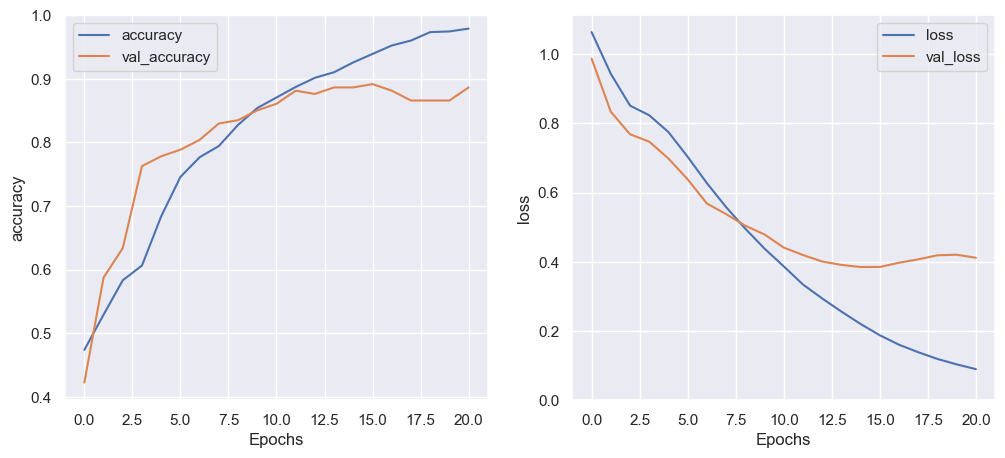

In [19]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_' + metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_' + metric])

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

plt.show()

In [20]:
test_loss, test_acc = model.evaluate(test_ds)

print('Test Loss:\t', test_loss)
print('Test Accuracy:\t', test_acc)

4/4 [==============================] - 0s 3ms/step - loss: 0.6172 - accuracy: 0.8205
Test Loss:	 0.6171514987945557
Test Accuracy:	 0.8205128312110901


We see at this point that the deep learning model achieves an accuracy of ~0.82 and a loss of ~0.61. An observation we can make is that this model overfits the<br>
data, as the training set accuracy is higher than the validation set accuracy and the loss is also increasing.

## Results and Visualizations

### Noun Chunk Extraction

In [21]:
gr_chars = "ΑαΆάΒβΓγΔδΕεΈέΖζΗηΉήΘθΙιΊίΚκΛλΜμΝνΞξΟοΌόΠπΡρΣσςΤτΥυΎύΦφΧχΨψΩωΏώ"

def remove_greek(desc):
    translation_table = dict.fromkeys(map(ord, gr_chars), None)
    return desc.translate(translation_table)

# Remove Greek words as the ads were meant for Greece
complete_df['description'] = complete_df['description'].apply(lambda x: remove_greek(x))

In [22]:
# Use regex to remove unwanted formating
replacements = {
    'e.g.': '', 'i.e.': '',                                           # Remove usual examples
    r'\b[\w\.-]+@[\w\.-]+\.\w{2,6}\b': '',                            # Remove e-mails
    r'(https?:\/\/)?([\da-z\.-]+)\.([a-z\.]{2,6})([\/\w \.-]*)': '',  # Remove links
    r'\B#([a-z0-9]{1,})': '',                                         # Remove hashtags
    r'[^\w\s+#]': ' ',                                                # Remove special characters
    r'(\s{2,})|(\n+)': ' '                                            # Remove new lines and whitespaces
}

complete_df['description'] = complete_df['description'].replace(replacements, regex=True)

In [23]:
nlp = spacy.load("en_core_web_sm")

noun_phrases = []
for doc in nlp.pipe(complete_df['description'].astype('unicode').values, batch_size=50, n_process=6):
    assert doc.has_annotation("DEP")
    for chunk in doc.noun_chunks:
        noun_phrases.append(chunk.text)

complete_df = pd.DataFrame(list(noun_phrases), columns=["chunks"])
print(f'Amount of noun chunks extracted: {len(complete_df)}')

Amount of noun chunks extracted: 31841


### Predictions

Let's see the frequency of the top extracted hard skills ngrams.

In [24]:
y_pred = model.predict(complete_df['chunks'])
complete_df['prediction'] = np.argmax(y_pred, axis=1)

996/996 [==============================] - 2s 2ms/step


In [25]:
def compute_frequencies(category: int):
    count_vectorizer = CountVectorizer(ngram_range=(1,2), analyzer='word', stop_words='english')
    sparse_matrix = count_vectorizer.fit_transform(complete_df[complete_df['prediction']==category]['chunks'])
    frequencies = sum(sparse_matrix).toarray()[0]
    ngrams = pd.DataFrame(frequencies, index=count_vectorizer.get_feature_names_out(), columns=['frequency'])
    return ngrams.sort_values(by='frequency', ascending=False)

compute_frequencies(1)[:10]

,frequency
data,707
experience,417
science,238
english,211
sql,198
ml,171
python,169
computer,160
azure,151
cloud,149


### Embedding Vectors

In [26]:
weights = model.get_layer('embedding').get_weights()[0]

inverse_voc = {}
for index, word in enumerate(vocabulary):
    inverse_voc[word] = index

In [27]:
# Function that accepts a word and returns the num most similar words to the given one
def most_similar(word, num):
    similar = []
    word_w = weights[inverse_voc[word]]
    for key, value in inverse_voc.items():
        if word == key:
            continue
        cosine = np.dot(word_w, weights[inverse_voc[key]])/(norm(word_w)*norm(weights[inverse_voc[key]]))
        similar.append((key, cosine))
        
    similar.sort(key=lambda x: x[1], reverse=True)
    #similar = sorted(similar, key=float, reverse=True)
        
    return similar[:num]

Let's explore for example the 10 most similar vectors to the word "Python".

In [28]:
pd.DataFrame(most_similar("python", 10), columns=['Word', 'Similarity'])

,Word,Similarity
0,spark,0.968041
1,aws,0.964613
2,google,0.955107
3,phd,0.953560
4,airflow,0.953549
5,azure,0.953231
6,java,0.953062
7,sql,0.952142
8,etl,0.951828
9,bi,0.951770


In [29]:
out_v = io.open('embeddings/conv_vectors.tsv',  'w', encoding='utf-8')
out_m = io.open('embeddings/conv_metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(vocabulary):
    if index == 0:
        continue  # skip 0, it's padding.
    vec = weights[index]
    out_v.write('\t'.join([str(x) for x in vec]) + "\n")
    out_m.write(word + "\n")
out_v.close()
out_m.close()

The exported model's weights and metadata can be used to visualize the vector space here: http://projector.tensorflow.org/

### Wordcloud Visualizations

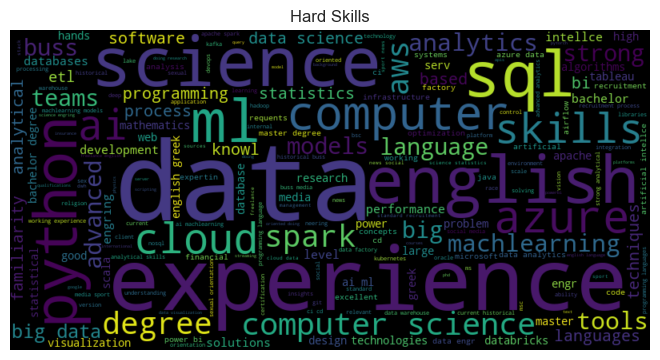

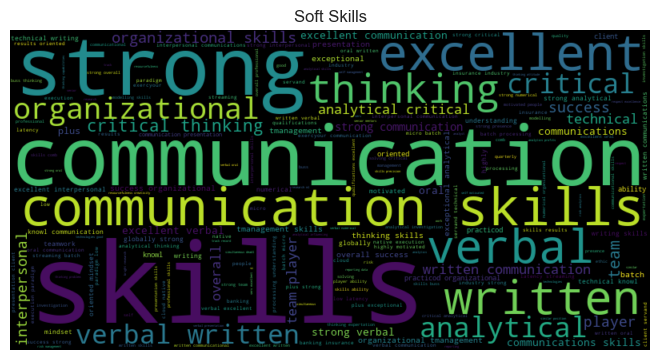

In [30]:
for category in range(1, 3):
    category_names = {
        1: 'Hard Skills',
        2: 'Soft Skills'
    }
    
    word_dict = compute_frequencies(category).to_dict()['frequency']
    wordcloud = WordCloud(width=800, height=400).generate_from_frequencies(word_dict)

    # Display wordcloud graphic
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(category_names[category])
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()